# Machine Learning Section

In [1]:
# Import necessary functions
# Data Wrangling
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install lightgbm

In [3]:
# !pip install catboost

## Load Data

In [4]:
df = pd.read_csv('data/student_data.csv')
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [5]:
df.columns = df.columns.str.lower()

## Defining appropriate X and y
To start out, we'll consider y to be the target variable (gradeclass) and everything else to be X

In [6]:
y = df["gradeclass"]
X = df.drop("gradeclass", axis=1)

## Train-Test Split
Specifying a random_state means that we will get consistent results even if the kernel is restarted

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing

### Dealing with Categorical Variables

- Binary Categorical Variables: 
  - `Gender, Tutoring, Extracurricular, Sports, Music, Volunteering`
    - These are already binary (0 or 1). No further encoding needed.
- Ordinal Variables:
  - `ParentalSupport`:
    - Since this has an inherent order, we can keep it as is (0 to 4). Machine learning models will handle this naturally
- Norminal Variables:
  - `Ethnicity, ParentalEducation`:
    - These have no inherent order, so we'll use One-Hot Encoding to avoid assigning artificial ordinal relationships.

In [8]:
# Identifying categorical features
binary_features = ['gender', 'tutoring', 'extracurricular', 'sports', 'music', 'volunteering']
ordinal_features = ['parentalsupport']
nominal_features = ['ethnicity', 'parentaleducation']

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), nominal_features),
        ('scale', StandardScaler(), ['studytimeweekly', 'absences', 'gpa'])
    ],
    remainder='passthrough' # Keep other features (e.g., binary and ordinal) as is
)
#Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
# Fit and transform on X_train, transform X_test
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)
#-----------------------------------------Prev code commented out------------------------------------
# # One-Hot Encoding for nominal features
# X_nominal_encoded = pd.get_dummies(X_train[nominal_features], drop_first=True)  # drop_first to avoid multicollinearity

# # Combine the encoded features with the rest of the dataset
# X_train_preprocessed = pd.concat([X_train.drop(nominal_features, axis=1), X_nominal_encoded], axis=1)

In [9]:
# Inspect shape on sets
print(X_train_transformed.shape)
print(X_test_transformed.shape)
# both X_train_transformed and X_test_transformed have the same number of columns (19 in this case),
# representing the features used for training and testing. This ensures that the model can process both 
# datasets seamlessly.

(1794, 19)
(598, 19)


**Side Note:** *Features like `Absences` or `StudyTimeWeekly` have extreme values (e.g., some students with 30 absences or 20 study hours), `StandardScaler` would handle these better by reducing the impact of outliers.*
*On the other hand, if all numeric features have consistent ranges and no outliers, `MinMaxScaler` might be simpler and equally effective.*

### Normalization (Scaling)
Now let's look at the numeric features. This time we'll also pay more attention to the meaning of the features, and only include relevant ones (e.g. not including `studentid` because this is a data artifact, not a true feature).

Another important data preparation practice is to normalize your data. That is, if the features are on different scales, some features may impact the model more heavily than others. To level the playing field, we often normalize all features to a consistent scale of 0 to 1.

As you can see, our features are currently not on a consistent scale:

## Feature Selection
Since some features might not conntribute significantly to our models' performance, or they might introduce noise altogether, we'll go ahead and remove irrelevant features to potentially reduce overfitting and improve interpretability

In [10]:
# Retrieve feature names from the ColumnTransformer or pipeline
feature_names = preprocessor.get_feature_names_out()

In [11]:
# Convert X_train_transformed to a pandas DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Check the DataFrame
X_train_transformed_df.head()

,onehot__ethnicity_1,onehot__ethnicity_2,onehot__ethnicity_3,onehot__parentaleducation_1,onehot__parentaleducation_2,onehot__parentaleducation_3,onehot__parentaleducation_4,scale__studytimeweekly,scale__absences,scale__gpa,remainder__studentid,remainder__age,remainder__gender,remainder__tutoring,remainder__parentalsupport,remainder__extracurricular,remainder__sports,remainder__music,remainder__volunteering
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.659514,0.286082,-0.088261,2831.0,16.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.033486,1.230391,-1.524547,2475.0,18.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.129705,-1.248419,0.672644,2323.0,15.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.610018,0.994314,-0.922379,1142.0,15.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.207836,-1.720574,1.809182,2420.0,15.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0


In [12]:
# Select numeric features from the DataFrame
numeric_features = X_train_transformed_df.select_dtypes(include=['float64', 'int64']).columns

a. Correlation Analysis (For Numeric Features)

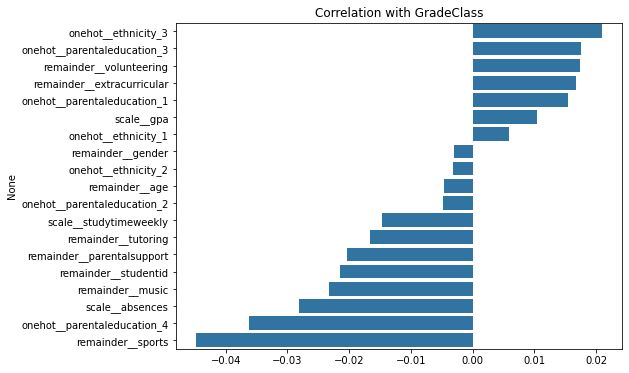

In [13]:
# Correlation with the target variable
corr_matrix = X_train_transformed_df[numeric_features].corrwith(pd.Series(y_train))

# Sort and plot the correlations
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = corr_matrix.sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index)
plt.title('Correlation with GradeClass')
plt.show()

b. Mutual Information (ForCategorical Features)

## Modeling

Model 1: Baseline Model - Random Forest

In [14]:
# Initialize the model
rf_baseline = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model to the training data
rf_baseline.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = rf_baseline.predict(X_test_transformed)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9214046822742475
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.58      0.71        31
         1.0       0.92      0.89      0.91        65
         2.0       0.88      0.92      0.90        90
         3.0       0.91      0.88      0.90       112
         4.0       0.94      0.98      0.96       300

    accuracy                           0.92       598
   macro avg       0.91      0.85      0.87       598
weighted avg       0.92      0.92      0.92       598



In [15]:
# Feature importance
importances = rf_baseline.feature_importances_
feature_importances_df = pd.DataFrame(
    {'Feature': X_train_transformed_df.columns, 'Importance': importances}
).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                        Feature  Importance
9                    scale__gpa    0.457417
8               scale__absences    0.168378
10         remainder__studentid    0.123961
7        scale__studytimeweekly    0.067899
14   remainder__parentalsupport    0.034954
11               remainder__age    0.023555
13          remainder__tutoring    0.013204
12            remainder__gender    0.013083
15   remainder__extracurricular    0.012099
16            remainder__sports    0.011708
1           onehot__ethnicity_2    0.010986
3   onehot__parentaleducation_1    0.009882
4   onehot__parentaleducation_2    0.009034
5   onehot__parentaleducation_3    0.008914
17             remainder__music    0.008805
0           onehot__ethnicity_1    0.008742
18      remainder__volunteering    0.008009
2           onehot__ethnicity_3    0.006942
6   onehot__parentaleducation_4    0.002428


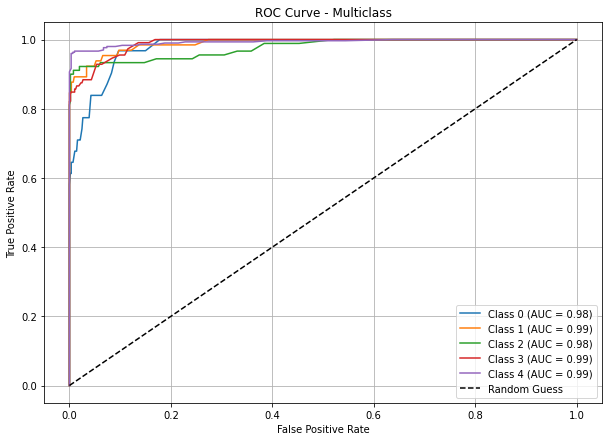

Macro AUC-ROC: 0.99
Weighted AUC-ROC: 0.99


In [16]:
# Binarize the output (needed for multiclass ROC)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # Your GradeClass classes
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities
y_pred_proba = rf_baseline.predict_proba(X_test_transformed)

# Initialize variables for plotting
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line for reference (random model)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multiclass")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Compute Overall AUC-ROC (macro and weighted)
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr", average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr", average="weighted")

print(f"Macro AUC-ROC: {macro_roc_auc:.2f}")
print(f"Weighted AUC-ROC: {weighted_roc_auc:.2f}")

**Metrics**
- Class-Specific AUC-ROC: Shows how well the model distinguishes a specific class from all others.
- Macro AUC-ROC: Averages AUC across all classes equally, giving each class the same importance.
- Weighted AUC-ROC: Averages AUC across all classes but weights by the number of samples in each class, reflecting the class distribution.

**Interpretation**
- *Class-Specific AUC Scores:*
Each class has an AUC score of 0.98 or higher, which indicates that the model performs extremely well in distinguishing each class from the others.
AUC values close to 1.0 mean the model is highly effective at separating the positive class from the negative classes for all thresholds.
Macro and Weighted AUC-ROC:

- *Macro AUC-ROC (0.99):*
This is the average of the AUC scores across all classes, treating all classes equally.
A score of 0.99 confirms that the model has consistently high performance across all classes.

- *Weighted AUC-ROC (0.99):*
This takes the class imbalance into account by weighting the AUC of each class based on its proportion in the dataset.
Since this value is also high, it indicates that the model performs well even for the minority classes (e.g., Class 0).
ROC Curve:

The curves are very close to the top-left corner, which signifies high true positive rates and low false positive rates for all classes.

Additional Models 

[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight, use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 0.9180602006688964
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68        31
         1.0       0.81      0.89      0.85        65
         2.0       0.91      0.93      0.92        90
         3.0       0.93      0.88      0.90       112
         4.0       0.97      0.96      0.96       300

    accuracy                           0.92       598
   macro avg       0.86      0.87      0.86       598
weighted avg       0.92      0.92      0.92       598



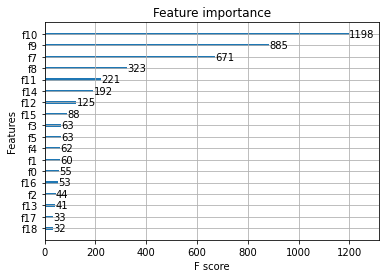

In [17]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, class_weight='balanced', eval_metric='mlogloss', random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_transformed)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance plot
xgb.plot_importance(xgb_model)
plt.show()

Additional Models - Pipelines

In [18]:
# Define feature groups
binary_features = ['gender', 'tutoring', 'extracurricular', 'sports', 'music', 'volunteering']
ordinal_features = ['parentalsupport']  # Assuming ordinal features are left unchanged
nominal_features = ['ethnicity', 'parentaleducation']
numeric_features = ['studytimeweekly', 'absences', 'gpa']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), nominal_features),  # One-hot encode nominal features
        ('scale', StandardScaler(), numeric_features)  # Scale numeric features
    ],
    remainder='passthrough'  # Keep binary and ordinal features unchanged
)

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=42),
    # Add other models here if needed
}

# Store results
results = []

for model_name, model in models.items():
    # Create pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Use the defined preprocessor
        ('classifier', model)  # Add the model
    ])
    
    # Cross-validate model
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    
    # Append results to a list
    results.append({"Model": model_name, "Accuracy Mean": mean_score, "Accuracy Std Dev": std_dev})

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

# Evaluate the best pipeline on the test set (example with Random Forest)
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))
])
best_pipeline.fit(X_train, y_train)

# Test set evaluation
y_pred = best_pipeline.predict(X_test)
print("\nBest Pipeline Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

[18:13:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

### Fitting a Model

### Performance on Training Data

### Performance on Test Data